# Efficient Language Model Serving 






























In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# remember to set CUDA_VISIBLE_DEVICES=0 before launching the notebook

### Import required packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', None)

import random
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [3]:
!nvidia-smi

Sun Apr 21 12:59:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     Off | 00000000:23:00.0 Off |                  N/A |
|  0%   38C    P8               9W / 200W |    148MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
torch.cuda.current_device()

0

# Sentiment Analysis Dataset

In [5]:
# Load sample dataset
df = pd.read_csv("datasets/better30.csv")

df.head()

,CONVERSATION_ID,CONVERSATION_STEP,TEXT,CONTEXT,LABEL,FEATURES,ANNOTATIONS
0,6,1,"Good morning, this is [Your Name]'s personal assistant. How can I help you today?",Standard opening exchange,neutral,NaN,NaN
1,6,2,"Hello, my name is Jamie. I'm interested in volunteering... [Step: 1] Good morning, Jamie! It's wonderful to hear about your interest in volunteering. We're always looking for passionate individuals to join our efforts.",Encourages the caller's interest,neutral,"welcoming, positive_tone",NaN
2,6,3,"Yes, I'm really passionate about environmental conservation... [Step: 2] That's fantastic, Jamie. There are no specific requirements; we welcome volunteers of all backgrounds. The main need is for willingness to participate and follow the event guidelines for safety and effectiveness.",Reinforces anyone can volunteer,neutral,inclusive,NaN
3,6,4,"Great, how do I sign up, and where can I find more information... [Step: 3] You can sign up through our official website. There's a volunteer registration section where you'll find all the information about the event, including date, location, and what to bring. Would you like me to guide you to the webpage or send you the link?",Demonstrates flexibility,neutral,"helpful_tone, offers_options",NaN
4,6,5,"Could you send me the link, please? And my email is jamie.green@example.com. [Step: 4] Absolutely, Jamie. I'll send the link to your email along with additional resources about the event. You should receive it within a few minutes.",Fulfills caller's request quickly,neutral,prompt_action,NaN


In [6]:
df.CONVERSATION_ID.min(), df.CONVERSATION_ID.max()

(0, 68)

In [7]:
import random
conv_id=random.randint(0, 68)
print(conv_id)

random_conversation = '\n'.join(df[df.CONVERSATION_ID==conv_id].TEXT.values.tolist())

49


In [8]:
prompt_template = """Using the provided text below, perform a sentiment analysis of the text. \
Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. \
Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment analysis, no other comment.
\n
********** BEGIN TEXT **********
{text}
********** END TEXT **********
"""


In [9]:
prompt = prompt_template.format(text=random_conversation)
print(prompt)

Using the provided text below, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment analysis, no other comment.


********** BEGIN TEXT **********
Hello, this is [Your Name]'s assistant. How may I assist you today?
Good morning, I'm Mark from QuickSupply Solutions. We've recently been selected as one of your new suppliers, and I need to verify some account details to set up our billing process.
That's great news. Can you provide me with the agreement number or the contact name from our procurement department who managed this selection?
I don't have that information on hand. I was just given your contact as the point person for verification. We need to confirm your company's billing address and account numbers to ensure there are no

In [10]:
# Batch processing

batch = ["\n".join(df[df.CONVERSATION_ID==conv_id].TEXT.values.tolist()) for conv_id in range(68)]

#batch = [prompt_template.format(text=p) for p in batch]

len(batch)


68

In [11]:
batch[0]

"Hello, this is [Your Name]'s personal assistant. How may I assist you today?\nHi, I'm Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I'm interested in registering but had a few questions. [Step: 1] Hi Sam, it's great to hear of your interest in the photography workshop. I'd be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I'm fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers. [Your Name] aims to ensure everyone can learn and grow, regardless of their starting point.\nThat sounds perfect. What's the registration process? [Step: 3] You can register through our website. I can guide you through the steps if you'd like, or send you a direct link to the registration page.\nA direct link would be great. Can you also tell me about the workshop fee? [Step: 4] Certainly, the fee for the workshop is $

# Model: Mistral-7B-Instruct

In [14]:
## Load Model: it will take few minutes if not cached

model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)



print(model)

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm(

In [16]:
model.to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacity of 7.79 GiB of which 86.94 MiB is free. Process 1550 has 132.68 MiB memory in use. Including non-PyTorch memory, this process has 7.55 GiB memory in use. Of the allocated memory 7.43 GiB is allocated by PyTorch, and 1.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [15]:
model.get_memory_footprint()/1e9




30.0406784

## Quantized model


<img src="ZeroPointQuantization.jpg" width="500"/>

In [12]:
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map='auto',
                                             load_in_4bit=True,
                                             )

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
print(f"Model size: {model.get_memory_footprint()/1e9:.2f}G")

Model size: 4.55G


In [14]:
device = model.device
device

device(type='cuda', index=0)

In [15]:
!nvidia-smi

Fri Apr 19 18:34:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     Off | 00000000:23:00.0 Off |                  N/A |
| 50%   39C    P2              40W / 200W |   5236MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
prompt_template = """<s>[INST] Using the provided text below, analyze the sentiment expressed within it. \
Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. \
Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment, no other comment.

********** BEGIN TEXT **********
{text}
********** END TEXT **********
[/INST]
"""

In [17]:
prompt = prompt_template.format(text=random_conversation)
print(prompt)

<s>[INST] Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment, no other comment.

********** BEGIN TEXT **********

********** END TEXT **********
[/INST]



In [18]:
prompts = [prompt_template.format(text=p) for p in batch]
prompts[0]

'<s>[INST] Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment, no other comment.\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers

## Generate  tokens

In [22]:
%%time
# input prompt tokenization

inputs = tokenizer(prompt, return_tensors="pt").to(device)
inputs['input_ids'].size()

CPU times: user 1.1 ms, sys: 8.34 ms, total: 9.44 ms
Wall time: 8.13 ms


torch.Size([1, 578])

In [23]:
inputs

{'input_ids': tensor([[    1,     1,   733, 16289, 28793,  9616,   272,  3857,  2245,  3624,
         28725, 20765,   272, 21790, 11558,  2373,   378, 28723,  5919,  7655,
          3161,   272, 21790,   349,  5278, 28725, 14214, 28725,   442,  7087,
          2818,   356,   272,  2758, 28725,  1707,  4782, 28725,   304,  7544,
         10294, 28723,  5713,   272,  5643,   349,  4160, 28725,  9421,   395,
           272, 21790, 16776,   390,  2477,   345,  3529,  2468,   548,   345,
          6947,   329,  1650,   548,   442,   345, 21436,  1197,  2586,    13,
         23805,   865,   395,   272, 21790, 28725,   708,   799,  4517, 28723,
            13,    13,   812,   348, 10368, 20856, 25775, 28705,   812,   348,
            13, 16230, 28725,   456,   349,   272,  3327, 13892,   302,   733,
         11159,  6620,  1592,  1602,   993,   315,  6031,   368,  3154, 28804,
            13, 23809, 28725,   378, 28809, 28713, 22282, 27901,  1101,   733,
          9977, 28747, 28705, 28740, 2

In [62]:
#inputs['input_ids']

In [24]:
## 3. Prefill and decode: optimizing token generation over multiple steps

### Text generation helper function
# The following helper function generates the next tokens given a set of input tokens

def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [25]:
%%time

token = generate_token(inputs)

CPU times: user 514 ms, sys: 136 ms, total: 650 ms
Wall time: 649 ms


In [26]:
tokenizer.decode(token)

'Pos'

In [27]:
# Use the helper function to generate multiple tokens in a loop
# Track the time it takes to generate each token
def generate_tokens(inputs, n_tokens):

    generated_tokens = []
    next_inputs = inputs
    durations_s = []
    for _ in range(n_tokens):
        t0 = time.time()
        next_token_id = generate_token(next_inputs)
        durations_s += [time.time() - t0]
    
        next_inputs = {
            "input_ids": torch.cat(
                [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
                dim=1),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]], device=device)],
                dim=1),
        }
    
        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens), durations_s




In [28]:
%%time

tokens, durations = generate_tokens(inputs, 4)

CPU times: user 2.79 s, sys: 1.63 s, total: 4.42 s
Wall time: 4.41 s


In [29]:
print(tokens)

Positive.The


In [30]:
# Durations (secs)
durations

[0.6570193767547607,
 0.6403017044067383,
 0.6410853862762451,
 0.6403515338897705]

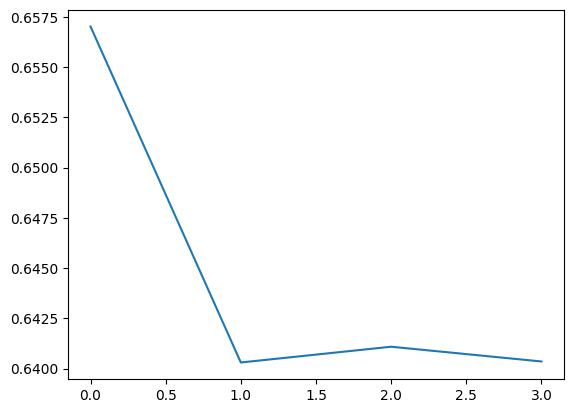

In [31]:
# Plot token generation time
# The x-axis here is the token number
# The y-axis is the time to generate a token in millisenconds (ms)
# **Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

plt.plot(durations)
plt.show()

### KV-caching

KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps


In [32]:
### Speeding up text generation with KV-caching
# KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps
# - Modify the generate helper function to return the next token and the key/value tensors

def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate_tokens_kv(inputs, n_tokens):
    generated_tokens = []
    next_inputs = inputs
    durations_cached_s = []
    for _ in range(n_tokens):
        t0 = time.time()
        next_token_id, past_key_values = \
            generate_token_with_past(next_inputs)
        durations_cached_s += [time.time() - t0]
    
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]], device=device)],
                dim=1),
            "past_key_values": past_key_values,
        }
    
        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens), durations_cached_s
    
    

In [33]:
# Generate tokens using the updated helper function
%time
tokens, durations_cached = generate_tokens_kv(inputs, 4)

print(f"{durations_cached}")
print(tokens)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.7 µs
[0.6566300392150879, 0.034284353256225586, 0.03355240821838379, 0.033393144607543945]
Positive.The


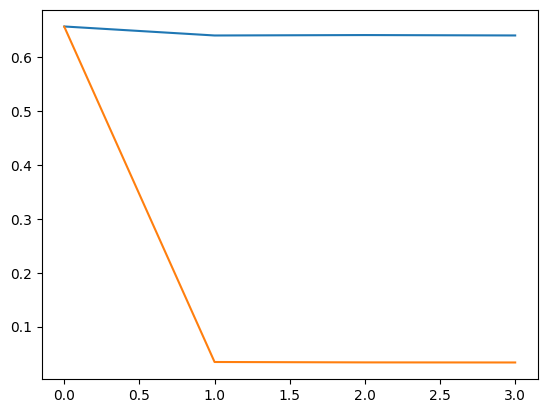

In [34]:
# Compare the execution time for the KV-cache function with the original helper function

# **Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

plt.plot(durations)
plt.plot(durations_cached)
plt.show()

## Batching

Tokenize list of prompts\
Add padding so that all prompts have the same number of tokens as the longest prompt

In [23]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [15]:
# multiple prompts of varying lengths to send
# to the model at once
prompts = [prompt_template.format(text=text) for text in batch[:20]]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt").to(device)

type(inputs)

transformers.tokenization_utils_base.BatchEncoding

In [15]:
prompts[0]

'<s>[INST] Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment, no other comment.\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers

In [16]:
inputs['input_ids'].size(), inputs["attention_mask"].size()

(torch.Size([20, 584]), torch.Size([20, 584]))

In [17]:
inputs

{'input_ids': tensor([[    2,     2,     2,  ..., 16289, 28793,    13],
        [    2,     2,     2,  ..., 16289, 28793,    13],
        [    2,     2,     2,  ..., 16289, 28793,    13],
        ...,
        [    2,     2,     2,  ..., 16289, 28793,    13],
        [    1,     1,   733,  ..., 16289, 28793,    13],
        [    2,     2,     2,  ..., 16289, 28793,    13]], device='cuda:0'), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], device='cuda:0')}

In [20]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


# Generate all tokens for some max tokens
# position_ids tell the transformer the ordinal position of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference, we need to 0 out the padding tokens at the start of the sequence

def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1), device=device),  
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [19]:
%%time

generated_tokens = generate_batch(inputs, max_tokens=4)

CPU times: user 16.7 s, sys: 2.21 s, total: 18.9 s
Wall time: 18.9 s


In [20]:
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

<s>[INST] Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment, no other comment.

********** BEGIN TEXT **********
Hello, this is [Your Name]'s personal assistant. How may I assist you today?
Hi, I'm Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I'm interested in registering but had a few questions. [Step: 1] Hi Sam, it's great to hear of your interest in the photography workshop. I'd be happy to help with any questions you have.
Thanks! I was wondering about the skill level required for participants. I'm fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers. [Your Name]

In [35]:
generated_tokens

['Positive.</s>',
 'Positive.</s>',
 'Negative.The',
 'Neutral.',
 'Neutral.',
 'Neutral.',
 'Positive.</s>',
 'Positive.</s>',
 'Neutral.',
 'Positive.The',
 'Neutral.',
 'Neutral</s>',
 'Neutral</s>',
 'Neutral</s>',
 'Neutral</s>',
 'Neutral.',
 'Positive.</s>',
 'Neutral.',
 'Neutral.',
 'Positive.The']

## Continuous Batching
The key idea behind continuous batching is constantly swap out requests from the batch that have completed generation for requests in the queue that are waiting to be processed.



![Continuous](ContinousBatching.jpg)

In [19]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [21]:
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 60
batch_size = 10
max_tokens = 4

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], max_tokens)
    for i in range(queue_size)
]

batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

len(request_queue), len(batches)

(60, 6)

In [22]:
# Processing batches
# generate tokens for all batches and record duration
t0 = time.time()
with tqdm(total=len(batches), desc=f"bs={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accommodate all the requests with our 
        # current implementation, we take the max of
        # all the tokens to generate among the requests
        #batch_max_tokens = [b[1] for b in batch]
        #max_tokens = max(batch_max_tokens)
        #print(max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})
        
        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt").to(device)
        generate_batch(inputs, max_tokens=max_tokens)
        
        pbar.update(1)

duration_s = time.time() - t0
print(f"Duration {duration_s:.2f}")


bs=10:   0%|          | 0/6 [00:00<?, ?it/s]

Duration 49.13


In [22]:
device

device(type='cuda', index=0)

In [56]:
prompts[0]

'Using the provided text below, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment analysis, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers. [Your

In [34]:
#os.environ['CUDA_VISIBLE_DEVICES']='0'

In [23]:
torch.cuda.current_device()

0

In [20]:
# Continuous batching

from utils import init_batch, get_next_inputs, get_next_inputs, generate_next_token, merge_batches, filter_batch, generate_batch_tokens_with_past
import copy

def generate(model, tokenizer, requests):
    global cached_batch
    # seed the random number generator so our results are deterministic
    random.seed(42)
    device = model.device
    # constants
    batch_size = 8
    request_queue = copy.copy(requests)
    
    responses = [None] * len(requests)

    # and run the initial prefill step
    batch = init_batch(tokenizer, request_queue[:batch_size], device=device)
    cached_batch = generate_next_token(model, tokenizer, batch, device=device)
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is fully drained and every input
    # within the cached_batch has completed generation
    while len(request_queue) > 0 or cached_batch["input_ids"].size(0) > 0:
        batch_capacity = batch_size - cached_batch["input_ids"].size(0)
        if batch_capacity > 0 and len(request_queue) > 0:
            #print("Prefilling, init new batch")
            # prefill
            new_batch = init_batch(tokenizer, request_queue[:batch_capacity],  device=device)
            #print("Generating new batch...")
            new_batch = generate_next_token(model, tokenizer, new_batch, device=device)
            request_queue = request_queue[batch_capacity:]

            # merge
            #print("Merging Batches...")
            cached_batch = merge_batches(cached_batch, new_batch,  device=device)
            #print("Batch merged.")
            

        # decode
        #print("Decoding...")
        cached_batch = generate_next_token(model, tokenizer, cached_batch, device=device)
        # remove any inputs that have finished generation
        #print("Filtering....")
        cached_batch, removed_indices, completed_responses = filter_batch(cached_batch, device=device)

        for idx, resp in zip(removed_indices, completed_responses):
            responses[idx] = resp
    
    return responses

In [21]:
device

device(type='cuda', index=0)

In [22]:
%%time
# constants
queue_size = 60
batch_size = 10
max_tokens = 4

request_queue = [
    (prompts[i], max_tokens)
    for i in range(queue_size)
]

responses = generate(model, tokenizer, request_queue)

OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacity of 7.79 GiB of which 10.94 MiB is free. Process 1550 has 132.68 MiB memory in use. Including non-PyTorch memory, this process has 7.63 GiB memory in use. Of the allocated memory 6.84 GiB is allocated by PyTorch, and 637.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [23]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Apr 19 18:36:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     Off | 00000000:23:00.0 Off |                  N/A |
| 60%   42C    P8              11W / 200W |   7962MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Using llama-cpp


In [25]:
!pip install aiohttp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:0031m16.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.7/128.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.1/328.1 kB 28.3 MB/s eta 0:00:00


### Single Request

In [12]:
### Load quantized model

from llama_cpp import Llama
model_name = 'models/mistral-7b-instruct-v0.2.Q4_K_M.gguf'


model = Llama(
    model_path=model_name,
    n_ctx=32768,  # The max sequence length to use - note that longer sequence lengths require much more resources
    n_threads=8,            # The number of CPU threads to use, tailor to your system and the resulting performance
    n_gpu_layers=35,        # The number of layers to offload to GPU, if you have GPU acceleration available
    chat_format="llama-2"
)

ModuleNotFoundError: No module named 'llama_cpp'

In [10]:
prompt

'Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, [Your Name]\'s personal assistant speaking. How can I help?\nThis is Ryan from City Power, calling about an urgent issue with your electricity bill. Immediate payment is required to avoid disconnection.\nI was unaware of any outstanding bill. Can you specify the amount and the billing period in question?\nThe outstanding amount is $450 for the last two months. We\'ve sent several notices to your registered address without response.\nTo verify this, I\'ll need to check our records and get back to you. Can I have a contact number and reference for this call?\nThere\'s no time f

In [128]:
%%time


# Simple inference example
output = model(
  prompt, # Prompt
  max_tokens=32,  # Generate up to 32 tokens
  stop=["</s>"],   # Example stop token - not necessarily correct for this specific model! Please check before using.
  echo=True        # Whether to echo the prompt
)

# Chat Completion API

#llm = Llama(model_path="./mistral-7b-instruct-v0.2.Q4_K_M.gguf", chat_format="llama-2")  # Set chat_format according to the model you are using
#llm.create_chat_completion(
#    messages = [
##        {"role": "system", "content": "You are a story writing assistant."},
#        {
#            "role": "user",
#            "content": "Write a story about llamas."
#        }
#    ]
#)




llama_print_timings:        load time =   13013.76 ms
llama_print_timings:      sample time =       0.66 ms /     3 runs   (    0.22 ms per token,  4566.21 tokens per second)
llama_print_timings: prompt eval time =   13416.17 ms /   541 tokens (   24.80 ms per token,    40.32 tokens per second)
llama_print_timings:        eval time =     560.09 ms /     2 runs   (  280.04 ms per token,     3.57 tokens per second)
llama_print_timings:       total time =   14000.03 ms /   543 tokens


CPU times: user 23.9 ms, sys: 931 ms, total: 955 ms
Wall time: 14 s


In [131]:
output['choices'][0]['text']

'<s>[INST] Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment, no other comment.\n\n********** BEGIN TEXT **********\nUsing the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, this is the personal assistant of [Your Name]. How may I assist you today?\nHi, I\'m Chris...interested in the new line of eco-friendly kitchen products... [Step: 1

In [132]:
output['usage']

{'prompt_tokens': 541, 'completion_tokens': 2, 'total_tokens': 543}

### Batch Processing

Install llama-cpp-python: https://llama-cpp-python.readthedocs.io/en/latest/install/macos/ \
Launch the server\
config your ggml model path\
make sure it is gguf v2\
make sure it is q4_0

To istall with CUDA support:
CMAKE_ARGS="-DLLAMA_CUDA=on" pip install llama-cpp-python

Run the following:
```
export MODEL='models/mistral-7b-instruct-v0.2.Q4_K_M.gguf' 
python -m llama_cpp.server --model $MODEL  --n_gpu_layers -1
```

It will start a server on default port 8000:
```
Guessed chat format: mistral-instruct
INFO:     Started server process [64719]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://localhost:8000 (Press CTRL+C to quit)
```

In [29]:
prompt_template

'<s>[INST] Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment, no other comment.\n\n********** BEGIN TEXT **********\n{text}\n********** END TEXT **********\n[/INST]\n'

In [28]:
batch = ["\n".join(df[df.CONVERSATION_ID==conv_id].TEXT.values.tolist()) for conv_id in range(68)]

batch = [prompt_template.format(text=p) for p in batch]


prompt = batch[random.randint(0,len(batch))]

print(random_conversation)


Hello, this is [Your Name]'s assistant. How may I assist you today?
Good morning, I'm Mark from QuickSupply Solutions. We've recently been selected as one of your new suppliers, and I need to verify some account details to set up our billing process.
That's great news. Can you provide me with the agreement number or the contact name from our procurement department who managed this selection?
I don't have that information on hand. I was just given your contact as the point person for verification. We need to confirm your company's billing address and account numbers to ensure there are no delays in our service delivery.
Before we proceed with any verification, it's essential that we receive official communication from our procurement department regarding this new supplier relationship. Could you send us an email with your request and any relevant documents?
I understand the need for security, but we're under a tight schedule to get everything set up. I was hoping to expedite the process

In [ ]:
curl --request POST \
--url http://localhost:8080/completion \
--header "Content-Type: application/json" \
--data '{"prompt": ["<s>[INST] What is the capital of the US? [/INST]", "<s>[INST] What is the capital of France? [/INST]"], "n_predict": 2048}'

In [126]:
# Using Completions API

url = "http://localhost:8002/v1/completions"


prompt = {
  "prompt": f"\n\n### Instructions:\n{random_conversation}\n\n### Response:\n",
  "stop": [
    "\n",
    "###"
  ]
}



In [118]:
%%time
r = requests.post(url, json=prompt)

CPU times: user 4.11 ms, sys: 2.5 ms, total: 6.61 ms
Wall time: 343 ms


In [119]:
r.json()['choices'][0]['text']

'Negative'

In [20]:
prompts = [{
  "prompt": f"\n\n### Instructions:\n{conversation}\n\n### Response:\n",
  "stop": [
    "\n",
    "###"
  ]
} for conversation in batch
]

In [26]:
## Simulating Parallel Requests
from aiohttp import ClientSession
import asyncio

import nest_asyncio
nest_asyncio.apply()



# Initialize the async client

async def predict(session: ClientSession, prompt: str) -> str:
    print("Requesting", url)
    async with session.post(url, json=prompt) as resp:
        reply = await resp.json()
        #await sleep(2)  # for demo purposes
        #print("Got response from", url, text.strip().split("\n", 1)[0])
        preds.append(reply['choices'][0]['text'])
        #predicted_ms.append(reply['timings']['predicted_ms'])
        #tokens_per_second.append(reply['timings']['predicted_per_second'])
        
        

async def get_all(prompts: list[dict], num_concurrent: int) -> None:
    prompt_iterator = iter(prompts)
    keep_going = True
    async with ClientSession() as session:
        while keep_going:
            tasks = []
            for _ in range(num_concurrent):
                try:
                    nextone = next(prompt_iterator)
                except StopIteration:
                    keep_going = False
                    break
                new_task = asyncio.create_task(predict(session, nextone))
                tasks.append(new_task)
            await asyncio.gather(*tasks)
            

In [138]:
# Test single request

async with ClientSession() as session:
    await predict(session, url, prompt)

Requesting http://localhost:8002/v1/completions


In [139]:
predicted

['Negative.']

In [163]:
%%time

# Test small batch
preds, predicted_ms, tokens_per_second = [], [], []


event_loop = asyncio.get_event_loop()
event_loop.run_until_complete(get_all(prompts, 16))

Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/comp

In [5]:
preds

NameError: name 'preds' is not defined

### Use llama.cpp server
For a detailed explanation of the server parameters, have a look [here](https://github.com/ggerganov/llama.cpp/blob/master/examples/server/README.md)


To install on linux with CUDA and 3060 GPU:

`make LLAMA_CUDA=1 CUDA_DOCKER_ARCH=sm86`

Download a quantized model from the HF [repo](https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF):

`huggingface-cli download TheBloke/Mistral-7B-Instruct-v0.2-GGUF mistral-7b-instruct-v0.2.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False
`

Launch:

`./server --model models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 -cb -np 16`
- cb: continuous batching
- np: number of slots (parallelism)



In [61]:
texts = ["\n".join(df[df.CONVERSATION_ID==conv_id].TEXT.values.tolist()) for conv_id in range(68)]

In [59]:
prompt_template = """Using the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text. \
Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. \
Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment analysis, no other comment.
\n
********** BEGIN TEXT **********
{text}
********** END TEXT **********
"""

In [62]:
batch = [prompt_template.format(text=text) for text in texts]
batch[0]

'Using the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment analysis, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to more experienc

In [70]:
url = "http://localhost:8080/v1/completions"

prompts = [{
    "prompt": f"\n\n{text}\n\n\n",
    "n_predict":4,
    "stop": [
        "\n",
        "###"
      ]
} for text in batch
]



In [66]:
prompts[0]

{'prompt': '\n\nUsing the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment analysis, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to

In [68]:
from aiohttp import ClientSession

async def predict(session: ClientSession, prompt: str) -> str:
    print("Requesting", url)
    async with session.post(url, json=prompt) as resp:
        reply = await resp.json()
        #await sleep(2)  # for demo purposes
        #print("Got response from", url, text.strip().split("\n", 1)[0])
        preds.append(reply['content'])
        preds_ms.append(reply['timings']['prompt_ms']+reply['timings']['predicted_ms'])
        tokens_per_second.append(reply['timings']['predicted_per_second'])

async def get_all(prompts: list[dict], num_concurrent: int) -> None:
    prompt_iterator = iter(prompts)
    keep_going = True
    async with ClientSession() as session:
        while keep_going:
            tasks = []
            for _ in range(num_concurrent):
                try:
                    nextone = next(prompt_iterator)
                except StopIteration:
                    keep_going = False
                    break
                new_task = asyncio.create_task(predict(session, nextone))
                tasks.append(new_task)
            await asyncio.gather(*tasks)


def results(preds, preds_ms, tokens_per_second):
    failed = len([i for i, v in enumerate(preds) if not v])
    predicted = len([i for i, v in enumerate(preds) if v])
    mean_pred_ms = np.mean([p for i, p in enumerate(preds_ms) if preds[i]])
    mean_tokens_pre_sec = np.mean([p for i, p in enumerate(tokens_per_second) if preds[i]])

    print(f"Succesfull predictions: {predicted}")
    print(f"Failed predictions: {failed}")
    print(f"Mean prediction time: {mean_pred_ms} ms")
    print(f"Tokens per second: {mean_tokens_pre_sec}")

In [97]:
# Single test
async with ClientSession() as session:
    async with session.post(url, json=prompts[0]) as resp:
        reply = await resp.json()

f"Replied: {reply['content']} in {reply['timings']['prompt_ms']+reply['timings']['predicted_ms']} ms."

'Replied: Neutral in 314.26 ms.'

In [73]:
batch20 = prompts[:20]


In [99]:
len(batch)

68

In [108]:
%%time

# Test small batch
preds, preds_ms, tokens_per_second = [], [], []


event_loop = asyncio.get_event_loop()
event_loop.run_until_complete(get_all(prompts, 16))

Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/comp

In [105]:

results(preds, preds_ms, tokens_per_second)

Succesfull predictions: 57
Failed predictions: 11
Mean prediction time: 1713.1050877192984 ms
Mean Tokens per second: 16.11586838643529


#### Experiment Results


`./server --model models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 -cb -np 16 -ngl 32`

```
Wall time: 6.72 s
num_concurrent = 4:
Mean prediction time: 1103.7863888888887 ms
Tokens per second: 32.80537293142969
```

`./server --model models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 -cb -np 16 -ngl 64`
```
Wall time: 5.33 s
num_concurrent = 4:
Mean prediction time: 845.2819999999999 ms
Tokens per second: 29.1984079263616
````



`./server --model models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 -cb -np 16 -ngl 128`
```
Wall time: 5.19 s
Mean prediction time: 769.3069375 ms
Tokens per second: 32.999395026172806
```

Whole Batch (68 calls)
```
num_concurrent = 4:
Wall time: 21.6 s
Mean prediction time: 963.6794210526316 ms
Tokens per second: 34.85750130200938
```

*****BEST SO FAR****)

`./server --model models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 -cb -np 16 -ngl 128`
```
num_concurrent = 16
Wall time: 19.1 s
Mean prediction time: 2675.847711864407 ms
Mean Tokens per second: 7.655980738400953
```
??? wall time lower but results look worse
```
num_concurrent = 8
Wall time: 20.6 s
Mean prediction time: 1713.1050877192984 ms
Mean Tokens per second: 16.11586838643529
```


# Lorax

Installation Guide can be found [here](https://loraexchange.ai/getting_started/local/)


pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu115

In [ ]:
from lorax import AsyncClient


# Batch of prompts to submit
prompts = [
    "The quick brown fox",
    "The rain in Spain",
    "What comes up",
]

# Initialize the async client
endpoint_url = "http://127.0.0.1:8080"
async_client = AsyncClient(endpoint_url)

# Submit all prompts and do not block on the response
t0 = time.time()
futures = []
for prompt in prompts:
    resp = async_client.generate(prompt, max_new_tokens=64)
    futures.append(resp)

# Await the completion of all the prompt requests
responses = await asyncio.gather(*futures)

# Print responses
# Responses will always come back in the same order as the original list
for resp in responses:
    print(resp.generated_text)

# Print duration to process all requests in batch
print("duration (s):", time.time() - t0)

# Finetuned Mistral: Zephyr-7b-dpo-qlora
[zephyr-7b-dpo-qlora](https://huggingface.co/alignment-handbook/zephyr-7b-dpo-qlora/tree/main)


Mistral-7b fine-tuned on Zephyr-7B dataset with DPO, a dataset of conversations. So this is a Mistral-7B finetuned to be an helpful assistant.\
The model has been finetuned using the [PEFT](https://huggingface.co/docs/peft/en/index) library.



In [134]:
#!pip install peft

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

config = PeftConfig.from_pretrained("alignment-handbook/zephyr-7b-dpo-qlora")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")
model = PeftModel.from_pretrained(model, "alignment-handbook/zephyr-7b-dpo-qlora")

Loading checkpoint shards:   0%|                                                                  | 0/2 [00:00<?, ?it/s]